In [61]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
import numpy as np
import matplotlib.pyplot as plt

In [62]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

In [63]:
import seaborn as sns

### Reading Data 

In [64]:
covid = pd.read_csv("bioactivity_data.csv")

In [65]:
covid.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,7.20
1,NaN,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,9.40
2,NaN,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,13.50
3,NaN,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,13.11
4,NaN,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,2.00


In [66]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   activity_comment           0 non-null      float64
 1   activity_id                133 non-null    int64  
 2   activity_properties        133 non-null    object 
 3   assay_chembl_id            133 non-null    object 
 4   assay_description          133 non-null    object 
 5   assay_type                 133 non-null    object 
 6   bao_endpoint               133 non-null    object 
 7   bao_format                 133 non-null    object 
 8   bao_label                  133 non-null    object 
 9   canonical_smiles           133 non-null    object 
 10  data_validity_comment      42 non-null     object 
 11  data_validity_description  42 non-null     object 
 12  document_chembl_id         133 non-null    object 
 13  document_journal           133 non-null    object 

### Creating new Dataset with required features

In [67]:
new = covid[['assay_chembl_id','canonical_smiles','standard_units','standard_value','units','value']]
new.head()

,assay_chembl_id,canonical_smiles,standard_units,standard_value,units,value
0,CHEMBL829584,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,nM,7200.0,uM,7.20
1,CHEMBL829584,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,nM,9400.0,uM,9.40
2,CHEMBL830868,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,nM,13500.0,uM,13.50
3,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,nM,13110.0,uM,13.11
4,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],nM,2000.0,uM,2.00


### Extracting different features from Smiles using Rdkit

In [68]:
new['Descriptor'] = new['canonical_smiles'].apply(lambda y: Chem.MolFromSmiles(y))
new['molecular_weight'] = new['Descriptor'].apply( lambda y: Descriptors.ExactMolWt(y))
new['HBD'] = new['Descriptor'].apply( lambda y: Descriptors.NumHDonors(y))
new['HBA'] = new['Descriptor'].apply( lambda y: Descriptors.NumHAcceptors(y))
new['MolLogP'] = new['Descriptor'].apply( lambda y: Descriptors.MolLogP(y))
new['PSA'] = new['Descriptor'].apply( lambda y: Descriptors.TPSA(y))
new['MolMR'] = new['Descriptor'].apply( lambda y: Descriptors.MolMR(y))
new['HeavyAtomCount'] = new['Descriptor'].apply( lambda y: Descriptors.HeavyAtomCount(y))
new['NHOHCount'] = new['Descriptor'].apply( lambda y: Descriptors.NHOHCount(y))
new['NOCount'] = new['Descriptor'].apply( lambda y: Descriptors.NOCount(y))
new.head()

C:\Users\HP\Anaconda3\envs\intuitive-deep-learning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\HP\Anaconda3\envs\intuitive-deep-learning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\HP\Anaconda3\envs\intuitive-deep-learning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,assay_chembl_id,canonical_smiles,standard_units,standard_value,units,value,Descriptor,molecular_weight,HBD,HBA,MolLogP,PSA,MolMR,HeavyAtomCount,NHOHCount,NOCount
0,CHEMBL829584,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,nM,7200.0,uM,7.20,<rdkit.Chem.rdchem.Mol object at 0x00000206E7C...,281.080041,0,5,1.89262,87.20,72.6545,21,0,6
1,CHEMBL829584,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,nM,9400.0,uM,9.40,<rdkit.Chem.rdchem.Mol object at 0x00000206E7D...,414.927232,0,2,3.81320,37.38,86.0895,21,0,3
2,CHEMBL830868,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,nM,13500.0,uM,13.50,<rdkit.Chem.rdchem.Mol object at 0x00000206E7D...,420.981106,0,4,2.66050,55.84,92.1955,23,0,5
3,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,nM,13110.0,uM,13.11,<rdkit.Chem.rdchem.Mol object at 0x00000206E7D...,293.051050,0,3,3.63080,37.38,83.7875,21,0,3
4,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],nM,2000.0,uM,2.00,<rdkit.Chem.rdchem.Mol object at 0x00000206E7D...,338.036128,0,5,3.53900,80.52,90.4419,24,0,6


In [69]:
newdata = new[new['standard_value']<1000000]
newdata = newdata[newdata['molecular_weight']<500]
newdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 132
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   assay_chembl_id   94 non-null     object 
 1   canonical_smiles  94 non-null     object 
 2   standard_units    94 non-null     object 
 3   standard_value    94 non-null     float64
 4   units             94 non-null     object 
 5   value             94 non-null     float64
 6   Descriptor        94 non-null     object 
 7   molecular_weight  94 non-null     float64
 8   HBD               94 non-null     int64  
 9   HBA               94 non-null     int64  
 10  MolLogP           94 non-null     float64
 11  PSA               94 non-null     float64
 12  MolMR             94 non-null     float64
 13  HeavyAtomCount    94 non-null     int64  
 14  NHOHCount         94 non-null     int64  
 15  NOCount           94 non-null     int64  
dtypes: float64(6), int64(5), object(5)
memory usa

### Finding correlation between different Descriptors

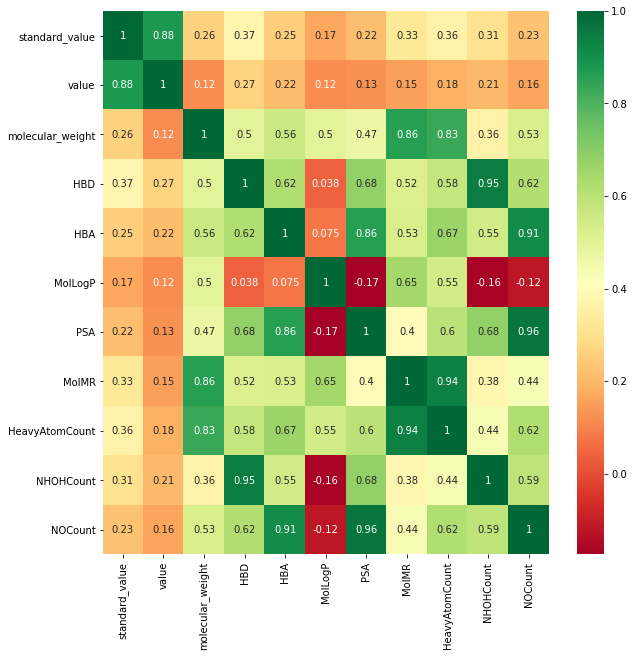

In [70]:
plt.figure(figsize=(10,10)) 
sns.heatmap(newdata.corr(),annot=True,cmap="RdYlGn")

### Seperating Data with float or Integer Values

In [170]:
reqdata = pd.concat([ newdata.iloc[:,8], newdata.iloc[:,9], newdata.iloc[:,11], newdata.iloc[:,12],newdata.iloc[:,13],newdata.iloc[:,14], newdata.iloc[:,15]],axis=1)
reqdata.head()

,HBD,HBA,PSA,MolMR,HeavyAtomCount,NHOHCount,NOCount
0,0,5,87.20,72.6545,21,0,6
1,0,2,37.38,86.0895,21,0,3
2,0,4,55.84,92.1955,23,0,5
3,0,3,37.38,83.7875,21,0,3
4,0,5,80.52,90.4419,24,0,6


### Preprocessing and Rescaling of Data

In [171]:
covid_val = reqdata.values

x = covid_val
Y = newdata.iloc[:,5].values

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(x)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.21, random_state = 10)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(74, 7) (74,) (20, 7) (20,)


### Fitting Data using Linear Regression

In [172]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

y_pred = regressor.predict(X_test)
reg_mse = mean_squared_error(Y_test, y_pred)
reg_rmse = np.sqrt(reg_mse)
reg_rmse

df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
df

r2 = r2_score(Y_test, y_pred) 
print('r2 score for given model is', r2) 

r2 score for given model is 0.14976534883745962


### Fitting Data using Tree Regression

In [173]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, Y_train)

y_pred = tree_reg.predict(X_test)
tree_mse = mean_squared_error(Y_test, y_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
df

r2 = r2_score(Y_test, y_pred) 
print('r2 score for given model is', r2) 

r2 score for given model is -2.0555138068337637


### Fitting Data using Polynomial Regression

In [174]:
Input = [('polynomial',PolynomialFeatures(degree=2)),('modal',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(X_train, Y_train)

y_pred = pipe.predict(X_test)
poly_mse = mean_squared_error(Y_test, y_pred)
poly_rmse = np.sqrt(tree_mse)
poly_rmse

df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
df

r2 = r2_score(Y_test, y_pred) 
print('r2 score for given model is', r2) 

r2 score for given model is -2.982735855687002


### Fitting Data using SVM Regression

In [175]:
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, Y_train)

y_pred = regressor.predict(X_test)
svm_mse = mean_squared_error(Y_test, y_pred)
svm_rmse = np.sqrt(tree_mse)
svm_rmse

df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
df

r2 = r2_score(Y_test, y_pred) 
print('r2 score for given model is', r2) 

r2 score for given model is -0.14403757287638985
